In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data Aggregate
* Combine and align data into Monthly Stock File (MSF)
* Use 3-Dimensional data structure as descriptor

In [2]:
msf_raw = pd.read_csv('data/msf_all.csv', low_memory=False)
indx = pd.MultiIndex.from_arrays(msf_raw.iloc[:, :2].values.T,
                                 names=['permno', 'date'])
col = ['TICKER', 'COMNAM', 'SICCD', 'RET',
       'BIDLO', 'ASKHI', 'PRC', 'VOL', 'SHROUT', 'vwretd', 'sprtrn']
msf = pd.DataFrame(data=msf_raw.loc[:, col].copy().values,
                   index=indx,
                   columns=col)

In [3]:
finr_raw = pd.read_csv('data/finratiofirm_all.csv')
indx = pd.MultiIndex.from_arrays(finr_raw.iloc[:, [0, 3]].values.T,
                                 names=['permno', 'date'])
col = ['pe_op_dil', 'pe_exi', 'roe', 'GProf', 'PEG_trailing', 'debt_assets', 'ptb', 'divyield']
finr = pd.DataFrame(data=finr_raw.loc[:, col].copy().values,
                    index=indx,
                    columns=col)
finr = finr.reindex(pd.MultiIndex.from_product(finr.index.levels, names=['permno', 'date']))

In [4]:
fff = pd.read_csv('data/mfff_all.csv').set_index('dateff')
fff.index.rename('date', inplace=True)

In [5]:
indx = pd.MultiIndex.from_product(
    [msf.index.levels[0].join(finr.index.levels[0], how='inner'),
     msf.index.levels[1].join(finr.index.levels[1])],
    names=['permno', 'date'])

In [6]:
msf = msf.reindex(indx).join(finr.reindex(indx))
msf.index.set_levels(pd.to_datetime(msf.index.levels[1]), level=1, inplace=True)

In [7]:
l = slice(None)
ll = (slice(None), slice(None))
msf.loc[ll, 'PRC'] = msf.loc[ll, 'PRC'].abs()
msf.loc[ll, 'BIDLO'] = msf.loc[ll, 'BIDLO'].abs()
msf.loc[ll, 'ASKHI'] = msf.loc[ll, 'ASKHI'].abs()
msf.loc[ll, 'divyield'] = msf.loc[ll, 'divyield'].astype('str').str.replace('%', '').astype('f') / 100
msf.loc[ll, 'rf'] = np.tile(fff.rf.values, indx.levels[0].shape)

In [8]:
msf.loc[ll, 'pe'] = msf.loc[ll, 'pe_exi'].fillna(method='ffill')
msf.loc[(msf.loc[ll, 'pe'] == 0), 'pe'] = np.nan
msf.loc[ll, 'eps_'] = msf.loc[ll, 'PRC'] / msf.loc[ll, 'pe']
msf.loc[ll, 'eps'] = msf.loc[ll, 'roe'] * msf.loc[ll, 'PRC'] / msf.loc[ll, 'ptb']
msf.loc[ll, 'eps'] = msf.loc[ll, 'eps'].fillna(method='ffill')

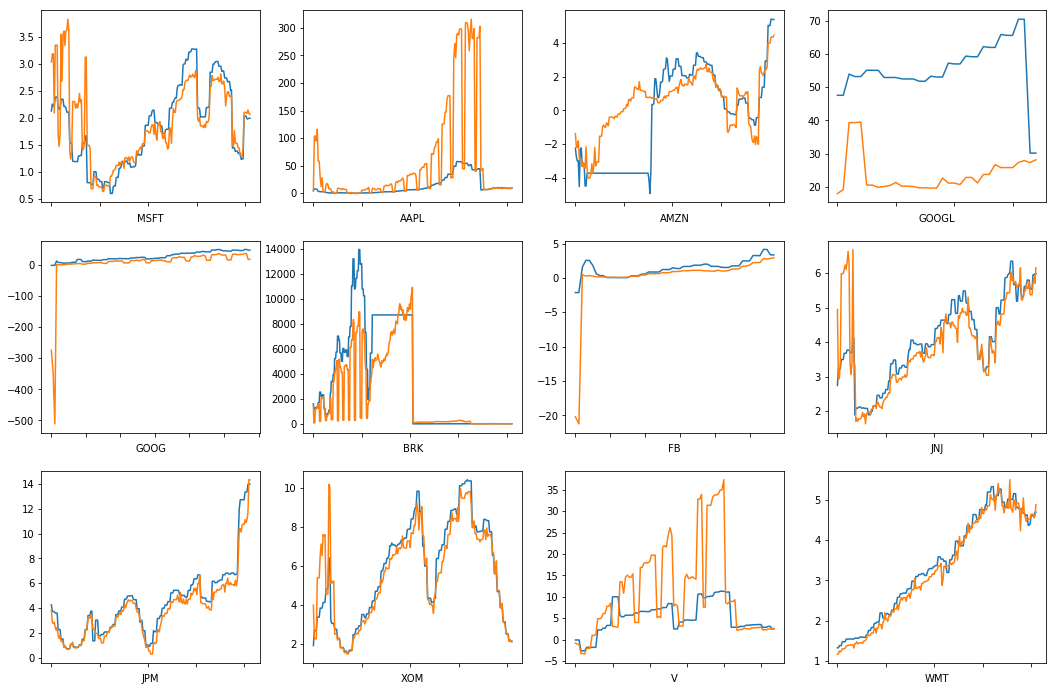

In [9]:
tickers = ['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'GOOG', 'BRK', 'FB', 'JNJ', 'JPM', 'XOM', 'V', 'WMT']
fig = plt.figure(figsize=(18, 12))
i = 0
for ticker in tickers:
    i = i + 1
    ax = fig.add_subplot(3, 4, i)
    msf.loc[(msf.TICKER == ticker), 'eps'].fillna(method='ffill').plot(ax=ax)
    msf.loc[(msf.TICKER == ticker), 'eps_'].fillna(method='ffill').plot(ax=ax)
    ax.set_xlabel(ticker)

## 2. Factor Construction
* Clean basic factor from market and fundimental data
* Calculate factor loading (exposure) as timeseries

> 1. Volatility  
  $\displaystyle log(\frac{ASKHI}{BIDLO})$

In [10]:
mesh = msf.loc[ll, 'BIDLO'].astype('str').str.contains('.', regex=False)
msf.loc[np.logical_not(mesh), 'BIDLO'].unique()

array([nan], dtype=object)

In [11]:
msf.loc[ll, 'volatility'] = msf.loc[ll, ['ASKHI', 'BIDLO']].astype('f').apply(np.log).dot([1,-1]).values

> 2. Momentum:  
  $\sum_t{log(1 + RET_t) - log(1 + rf_t)}$

In [12]:
mesh = msf.loc[ll, 'RET'].astype('str').str.contains('.', regex=False)
msf.loc[~mesh, 'RET'].unique()

array([nan, 'B', 'C'], dtype=object)

In [13]:
msf.loc[ll, 'RET'] = msf.loc[ll, 'RET'].replace({'B': 'NaN', 'C': 'NaN'})

In [14]:
msf.loc[ll, 'momentum'] = \
    np.log(1 + msf.loc[ll, ['RET', 'rf']].astype('f')).groupby(level=0).rolling(12).sum().dot([1,-1]).values

> 3. Size:  
  $log(PRC * SHROUT)$

In [15]:
msf.loc[ll, 'size'] = np.log((msf.loc[ll, 'PRC'] * msf.loc[(l, l), 'SHROUT']).astype('f'))

> 4. Size Nonlinearity:  
  $log^3(PRC * SHROUT)$

In [16]:
msf.loc[ll, 'size_nl'] = msf.loc[ll, 'size'] ** 3

> 5. Trading Activity:  
  $\displaystyle\frac{\sum_t{VOL}}{\frac{1}{T}\sum_t{SHROUT}}$

In [17]:
msf.loc[ll, 'trading_activity'] = (msf.loc[ll, 'VOL'].groupby(level=0).rolling(6).sum().values 
                                   / msf.loc[ll, 'SHROUT'].groupby(level=0).rolling(6).mean().values)

> 6. Growth:  
  $\displaystyle\frac{EPS_T - EPS_{T-1}}{EPS_T + EPS_{T-1}}$

In [18]:
msf.loc[(msf.loc[ll, 'eps'] == 0), 'eps'] = np.nan
eps_t = msf.loc[ll, 'eps'].groupby(level=0).rolling(12).sum()
eps_t0 = eps_t.values
eps_t1 = eps_t.groupby(level=0).shift(1).values
msf.loc[ll, 'growth'] = (eps_t0 - eps_t1) / (eps_t0 + eps_t1)

> 7. Earning Yield:  
  $\displaystyle\frac{\frac{1}{T}\sum_t{EPS}}{\frac{1}{T}\sum_t{PRC}}$

In [19]:
msf.loc[ll, 'earning_yield'] = (msf.loc[ll, 'eps'].groupby(level=0).rolling(24).mean().values 
                                / msf.loc[ll, 'PRC'].groupby(level=0).rolling(24).mean().values)

> 8. Value:  
  $\displaystyle\frac{1}{ptb}$

In [20]:
msf.loc[ll, 'value'] = 1 / msf.loc[ll, 'ptb'].fillna(method='ffill')

> 9. Earning Variability:  
  $\displaystyle\frac{\sigma^2(EPS)}{\mathbb{E}(EPS)}$

In [21]:
msf.loc[ll, 'earning_variability'] = (msf.loc[ll, 'eps'].groupby(level=0).rolling(12).var().values 
                                      / msf.loc[ll, 'eps'].groupby(level=0).rolling(12).mean().values)

> 10. Leverage:  
  $debt\_assets$

In [22]:
msf.loc[ll, 'leverage'] = msf.loc[ll, 'debt_assets'].fillna(method='ffill').abs()

> 11. Dividend Yield:  
  $divyield$

In [23]:
msf.loc[ll, 'divyield'] = msf.loc[ll, 'divyield'].fillna(method='ffill')

In [ ]:
pool = pd.read_csv('data/pool.csv')
capm = pd.read_csv('data/capm.csv')
indx_hsig = pd.MultiIndex.from_arrays(capm.iloc[:, [0, 5]].values.T,
                                      names=['permno', 'date'])
hsig = pd.DataFrame(data=capm.hsigma.values,
                    index=indx_hsig,
                    columns=['hsigma'])
indx_expo = pd.MultiIndex.from_product(
    [msf.index.levels[0],
     msf.index.levels[1].astype('str').str.replace('-', '').astype('int') // 100],
    names=['permno', 'date'])
expo = pd.DataFrame(data=msf.loc[ll, ['RET'] + factors].values,
                    index=indx_expo,
                    columns=['RET'] + factors)
ext = expo.loc[(pool.permno, l), :].join(hsig, how='inner')
ext.to_csv('data/ext.csv')